In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
from scipy.fftpack import fftn, ifftn
import oommfc as oc
from tqdm import tqdm

In [3]:
region = df.Region(p1=(-50e-9, -50e-9, -10e-9), p2=(50e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(2.5e-9, 2.5e-9, 2.5e-9))

system = mm.System(name='skyrmion')

system.energy = (mm.Exchange(A=1.6e-11)
               + mm.DMI(D=4e-3, crystalclass='D2d_z')
               + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 2e5)))
# system.energy = mm.DMI(D=4e-3, crystalclass='Cnv_z')

Ms = 1.1e6

def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero outside cylindric shape,
    Ms inside cylinder.

    Cylinder radius is 50nm.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 50e-9:
        return Ms
    else:
        return 0

def m_init(pos):
    """Function to set initial magnetisation direction:
    -z inside cylinder (r=10nm),
    +z outside cylinder.
    y-component to break symmetry.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 10e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

In [4]:
system.energy

Exchange(A=1.6e-11) + DMI(D=0.004, crystalclass='D2d_z') + UniaxialAnisotropy(K=510000.0, u=(0, 0, 1)) + Demag() + Zeeman(H=(0, 0, 200000.0))

In [6]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
# system.m.plane('z').mpl()

Running OOMMF (ExeOOMMFRunner)[2023/08/13 15:17]... (3.2 s)


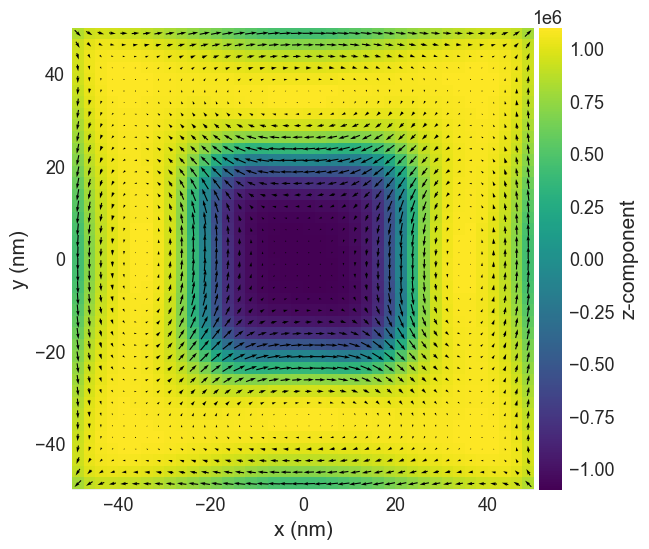

In [7]:
system.m.plane('z').mpl()

In [8]:
class MCDriver():
    def __init__(self, system) -> None:
        self.m0 = 4*np.pi*1e-7 # Tm/A
        self.grid = system.m.array
        magnitudes = np.linalg.norm(self.grid, axis=-1)
        magnitudes[magnitudes == 0] = 1 #avoid division by zero
        self.grid = self.grid/magnitudes[..., np.newaxis] #normalise vectors to get m(r)
        self.dx, self.dy, self.dz = system.m.mesh.cell
        self.temperature = system.T + 0.1 #avoid division by zero
        self.Kb = 1.38064852e-23 #Boltzmann constant
        # What about multiple similar energy terms????
        try:
            self.zeeman_K = system.energy.zeeman.H
        except:
            self.zeeman_K = None
        try:
            self.exchange_A =  system.energy.exchange.A
        except:
            self.exchange_A = None
        try:
            self.dmi_D = system.energy.dmi.D
            print(type(self.dmi_D))

            self.Dtype = system.energy.dmi.crystalclass
        except:
            self.dmi_D = None
        try:
            self.anisotropic_K, self.anisotropic_u = (system.energy.uniaxialanisotropy.K, np.array(system.energy.uniaxialanisotropy.u))
        except:
            self.anisotropic_K, self.anisotropic_u = (None, None)
        try:
            self.demag_N = system.energy.demag.N
        except:
            self.demag_N = None
            
    def zeeman_energy(self):
        if self.zeeman_K is None:
            return 0
        # create a grid shape validation for length of grids shape less than 2 and more than 4 are not supported
        if len(self.grid.shape) < 2 or len(self.grid.shape) > 4:
            raise ValueError("Grid shape is not supported")

        energy = -self.m0*Ms*np.sum(np.dot(self.grid, self.zeeman_K)*self.dx*self.dy*self.dz)
        return energy
    
    def anisotropic_energy(self): # only uniaxial anisotropy is supported
        if self.anisotropic_K is None:
            return 0
        
        energy = np.cross(self.grid, self.anisotropic_u)
        energy = self.anisotropic_K*np.sum(np.sum(energy**2, axis=-1))*self.dx*self.dy*self.dz #total energy of the system

        return energy
    
    def exchange_energy(self):
        if self.exchange_A is None:
            return 0
        # compute the Laplacian
        grid = np.pad(self.grid, ((1, 1), (1, 1), (1, 1), (0, 0)), mode='edge') # 'constant'
        # calculate the laplacian using (f(x + h) + f(x - h) - 2f(x))h^2

        laplacian_M = (((grid[2:, 1:-1, 1:-1] - 2 * grid[1:-1, 1:-1, 1:-1] + grid[:-2, 1:-1, 1:-1])/self.dx**2) + \
                       ((grid[1:-1, 2:, 1:-1] - 2 * grid[1:-1, 1:-1, 1:-1] + grid[1:-1, :-2, 1:-1])/self.dy**2) + \
                       ((grid[1:-1, 1:-1, 2:] - 2 * grid[1:-1, 1:-1, 1:-1] + grid[1:-1, 1:-1, :-2])/self.dz**2)
                    )
                    
        energy = np.sum(self.grid*laplacian_M) #dot product of m and laplacian_M
        energy = -self.exchange_A*energy*self.dx*self.dy*self.dz #total energy of the system
        return energy
    
    def dmi_energy(self):
        if self.dmi_D is None:
            return 0

            
        grid = np.pad(self.grid, ((1, 1), (1, 1), (1, 1), (0, 0)), mode='edge') # 'constant'

        if self.type == 'Cnv_z':
            #calculate gradient of z component of m vector with respect to each axis
            gradM_z = np.empty_like(self.grid, dtype='float64')
            gradM_z[..., 0] = (grid[2:, 1:-1, 1:-1, 2] - grid[:-2, 1:-1, 1:-1, 2]) / (2 * self.dx)
            gradM_z[..., 1] = (grid[1:-1, 2:, 1:-1, 2] - grid[1:-1, :-2, 1:-1, 2]) / (2 * self.dy)
            gradM_z[..., 2] = (grid[1:-1, 1:-1, 2:, 2] - grid[1:-1, 1:-1, :-2, 2]) / (2 * self.dz)


            #divergence of m vector
            div_M = ((grid[2:, 1:-1, 1:-1, 0] - grid[:-2, 1:-1, 1:-1, 0]) / (2 * self.dx) +
                    (grid[1:-1, 2:, 1:-1, 1] - grid[1:-1, :-2, 1:-1, 1]) / (2 * self.dy) +
                    (grid[1:-1, 1:-1, 2:, 2] - grid[1:-1, 1:-1, :-2, 2]) / (2 * self.dz)
                )
            
            m_del_mz = np.sum(self.grid*gradM_z, axis=-1) #dot product of m and gradient of z component of m vector
            mz_div_m = self.grid[..., 2]*div_M  # mz∇⋅m

            energy = self.dmi_D * (np.sum(m_del_mz) - np.sum(mz_div_m)) * self.dx * self.dy * self.dz #Total energy of the system
        
        
        elif self.type == 'D2d_z':
  
            # gradM_x = np.empty_like(self.grid, dtype='float64')
            # gradM_x[..., 0] = (grid[2:, 1:-1, 1:-1, 0] - grid[:-2, 1:-1, 1:-1, 0]) / (2 * self.dx)
            # gradM_x[..., 1] = (grid[1:-1, 2:, 1:-1, 0] - grid[1:-1, :-2, 1:-1, 0]) / (2 * self.dy)
            # gradM_x[..., 2] = (grid[1:-1, 1:-1, 2:, 0] - grid[1:-1, 1:-1, :-2, 0]) / (2 * self.dz)
            
            # gradM_y = np.empty_like(self.grid, dtype='float64')
            # gradM_y[..., 0] = (grid[2:, 1:-1, 1:-1, 1] - grid[:-2, 1:-1, 1:-1, 1]) / (2 * self.dx)
            # gradM_y[..., 1] = (grid[1:-1, 2:, 1:-1, 1] - grid[1:-1, :-2, 1:-1, 1]) / (2 * self.dy)
            # gradM_y[..., 2] = (grid[1:-1, 1:-1, 2:, 1] - grid[1:-1, 1:-1, :-2, 1]) / (2 * self.dz)

            gradM_x = np.empty_like(self.grid, dtype='float64')
            gradM_x[..., 0] = (grid[2:, 1:-1, 1:-1, 0] - grid[:-2, 1:-1, 1:-1, 0]) / (2 * self.dx)
            gradM_x[..., 1] = (grid[1:-1, 2:, 1:-1, 1] - grid[1:-1, :-2, 1:-1, 1]) / (2 * self.dy)
            gradM_x[..., 2] = (grid[1:-1, 1:-1, 2:, 2] - grid[1:-1, 1:-1, :-2, 2]) / (2 * self.dz)
            
            gradM_y = np.empty_like(self.grid, dtype='float64')
            gradM_y[..., 0] = (grid[2:, 1:-1, 1:-1, 0] - grid[:-2, 1:-1, 1:-1, 0]) / (2 * self.dx)
            gradM_y[..., 1] = (grid[1:-1, 2:, 1:-1, 1] - grid[1:-1, :-2, 1:-1, 1]) / (2 * self.dy)
            gradM_y[..., 2] = (grid[1:-1, 1:-1, 2:, 2] - grid[1:-1, 1:-1, :-2, 1]) / (2 * self.dz)


            #dm/dx x ^x - dm/dy x ^y
            cross_x = np.cross(gradM_x, np.array([1, 0, 0], dtype='float64'))
            cross_y = np.cross(gradM_y, np.array([0, 1, 0], dtype='float64'))
            res = cross_x - cross_y

            #Total energy
            energy =  self.dmi_D * np.sum(self.grid*res) * self.dx * self.dy * self.dz 
        
        elif self.type == 'Cnv_xy':
            # TODO: implement Cnv_xy
            raise NotImplementedError("Cnv_xy is not implemented yet")

        else:    
            curl = np.empty_like(self.grid, dtype='float64')
            curl[..., 0] = (grid[1:-1, 2:, 1:-1, 2] - grid[1:-1, :-2, 1:-1, 2]) / (2 * self.dy) - \
                                    (grid[1:-1, 1:-1, 2:, 1] - grid[1:-1, 1:-1, :-2, 1]) / (2 * self.dz)
            
            curl[..., 1] = (grid[1:-1, 1:-1, 2:, 0] - grid[1:-1, 1:-1, :-2, 0]) / (2 * self.dz) - \
                                    (grid[2:, 1:-1, 1:-1, 2] - grid[:-2, 1:-1, 1:-1, 2]) / (2 * self.dx)
            
            curl[..., 2] = (grid[2:, 1:-1, 1:-1, 1] - grid[:-2, 1:-1, 1:-1, 1]) / (2 * self.dx) - \
                                    (grid[1:-1, 2:, 1:-1, 0] - grid[1:-1, :-2, 1:-1, 0]) / (2 * self.dy)
            
            energy= np.sum(grid*curl, axis=-1) # dot product of m and curl
            energy = self.dmi_D*np.sum(energy)*self.dx*self.dy*self.dz # total energy of the system

        return energy
    


    def demagnetization_energy(self):
        
        # Calculate the volume of a single grid cell (assuming unit cell size)
        dV = self.dx * self.dy * self.dz
        
        # Fourier transform of the magnetization
        M_fft = fftn(self.grid, axes=(0, 1, 2))
        
        # Demagnetization tensor for a cubic geometry (in Fourier space)
        N = 1/3
        N_tensor = np.array([[[[N, 0, 0], [0, N, 0], [0, 0, N]]]])
        
        # Fourier transform of the demagnetization field
        H_d_fft = -N_tensor * M_fft
        
        # Inverse Fourier transform to get the demagnetization field in real space
        H_d = np.real(ifftn(H_d_fft, axes=(0, 1, 2)))
        
        # Calculate the demagnetization energy
        E_d = -0.5 * np.sum(self.grid * H_d) * dV
        
        return E_d

    
    def total_energy(self):
        return self.zeeman_energy() + self.anisotropic_energy() + self.exchange_energy() + self.dmi_energy()
    
    def driver(self, N):

        E_before = self.total_energy()

        for i in tqdm(range(N)):
            # 1. Randomly select a cell
            cell_x, cell_y, cell_z = np.random.randint(0, self.grid.shape[:3]) 

            while np.all(self.grid[cell_x , cell_y, cell_z] == 0): #if the cell is empty, select another cell
                cell_x, cell_y, cell_z = np.random.randint(0, self.grid.shape[:3]) 
            # 2Randomly select a direction by introducing some uniform noise to the existing direction

            # direction = self.grid[cell_x, cell_y, cell_z] + np.random.normal(-0.1, 0.1, size=3)
            direction = self.grid[cell_x, cell_y, cell_z] + np.random.uniform(-0.1, 0.1, size=3)

            direction = direction/np.linalg.norm(direction) #normalise the direction vector

            #3 Change the direction of the cell
            prev_direction = np.copy(self.grid[cell_x, cell_y, cell_z])
            self.grid[cell_x, cell_y, cell_z] = direction
            
            # 4 Calculate the energy of the system after the change
            E_after = self.total_energy()

            # 5 If energy is lower than previous energy, accept the change
            delta_E = E_after - E_before

            if delta_E < 0: #if energy is lower than previous energy, accept the change
                E_before = E_after


            else: #if energy is higher than previous energy, accept the change with probability exp(-dE/kT)
                R = np.exp(-delta_E/(self.Kb*self.temperature))
                if np.random.uniform(0, 1) < R:
                    E_before = E_after


                else:
                    self.grid[cell_x, cell_y, cell_z] = prev_direction #revert the change
            
        return self.grid

In [9]:
mc2 = MCDriver(system)

<class 'float'>


In [27]:
zeeman_ubermag = oc.compute(system.energy.zeeman.energy, system)
zeeman_MC = mc2.zeeman_energy()
print(zeeman_ubermag, zeeman_ubermag)
print("Zeeman Energy is equal: ", np.allclose(zeeman_ubermag, zeeman_MC))


Running OOMMF (ExeOOMMFRunner)[2023/08/12 11:22]... (2.0 s)
-3.03678720842e-17 -3.03678720842e-17
Zeeman Energy is equal:  True


In [28]:
exchange_ubermag = oc.compute(system.energy.exchange.energy, system)
exchange_MC = mc2.exchange_energy()
print(exchange_ubermag, exchange_MC)
print("Exchange energy is equal: ", np.allclose(exchange_ubermag, exchange_MC))


Running OOMMF (ExeOOMMFRunner)[2023/08/12 11:22]... (1.1 s)
2.77070581835e-17 2.7707058183477055e-17
Exchange energy is equal:  True


In [29]:
anisotropic_ubermag = oc.compute(system.energy.uniaxialanisotropy.energy, system)
anisotropic_MC = mc2.anisotropic_energy()
print(anisotropic_ubermag, anisotropic_MC)
print("anisotropic energy is equal: ", np.allclose(anisotropic_ubermag, anisotropic_MC))

Running OOMMF (ExeOOMMFRunner)[2023/08/12 11:22]... (1.1 s)
3.14857542983e-17 3.1485754298348433e-17
anisotropic energy is equal:  True


In [30]:
dmi_ubermag = oc.compute(system.energy.dmi.energy, system)
dmi_MC = mc2.dmi_energy()
print(dmi_ubermag, dmi_MC)
print("DMI energy is equal: ", np.allclose(dmi_ubermag, dmi_MC))

Running OOMMF (ExeOOMMFRunner)[2023/08/12 11:22]... (1.2 s)
-6.31323899115e-17 -3.3028973639203534e-17
DMI energy is equal:  True


In [20]:
mc2.type

'D2d_z'

In [15]:
oc.compute(system.energy.demag.energy, system)

Running OOMMF (ExeOOMMFRunner)[2023/08/08 12:46]... (7.7 s)


5.69160893451e-17

In [16]:
mc2.demagnetization_energy()

ValueError: operands could not be broadcast together with shapes (1,1,3,3) (40,40,4,3) 

In [20]:
new_grid = mc2.driver(5000000)

100%|██████████| 5000000/5000000 [2:52:29<00:00, 483.12it/s]  


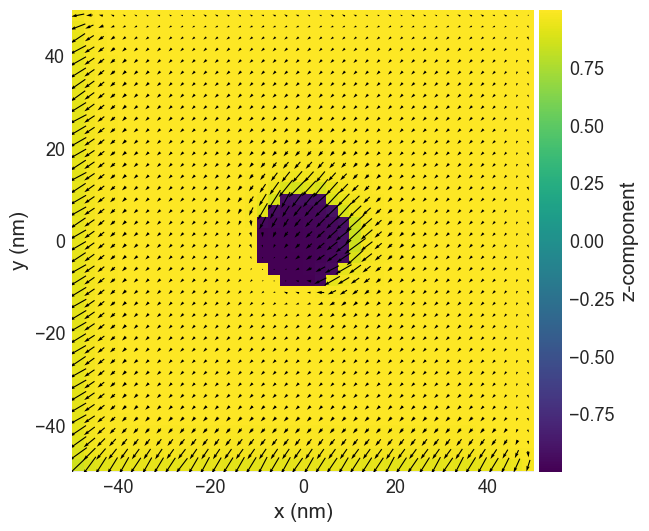

In [22]:
system.m.array = new_grid
system.m.plane('z').mpl()

## Questions to ask:

1. Little difference between oommfc and my dmi
2. Why did I revese the u vector in anisotrophic energy?
3. How will I be graded because I am using np.gradient which calculates 1sy order accurate at the boundaries.

## Performance
1. Energy calculation is done once per iteration this gives a performance advantage because the gradient, laplacian are not calculated twice.
2. For 10000 iteartions this takes about 6.5seconds 
